In [ ]:
data_dir = '/kaggle/input/indoor-object-detection/'
train_dir = data_dir + 'train'
test_dir = data_dir + 'test'
valid_dir = data_dir + 'valid'

#train_dataset = datasets.ImageFolder(train_dir, data_transforms['train'])

!tree "/kaggle/input/indoor-object-detection/" -L 2

/kaggle/input/indoor-object-detection/
|-- data.yaml
|-- test
|   |-- images
|   `-- labels
|-- train
|   |-- images
|   `-- labels
`-- valid
    |-- images
    `-- labels

9 directories, 1 file


In [ ]:
!pip install --upgrade ultralytics
!pip install --upgrade -U ray[tune]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.3/887.3 kB 14.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.3/66.3 MB 26.8 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: ray
    Found existing installation: ray 2.24.0
    Uninstalling ray-2.24.0:
      Successfully uninstalled ray-2.24.0


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import glob
import random
import yaml

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

# import IPython.display as display
from PIL import Image
import cv2

from ultralytics import YOLO
import time

%matplotlib inline

!wandb disabled # use if you have Weights and Biases installed

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
W&B disabled.


In [ ]:
# Клас, у якому будемо зберігати всі конфігурації, необхідні для навчання моделі.

class CFG:
    DEBUG = False # Set to True to make quick experiments
    FRACTION = 0.05 if DEBUG else 1.0 # Specifies the fraction of the dataset to use for training. Allows for training on a subset of the full dataset, useful for experiments or when resources are limited.
    SEED = 42

    # classes
    CLASSES = ['door', 'openedDoor', 'cabinetDoor', 'refrigeratorDoor', 'window',
               'chair', 'table','cabinet','sofa/couch','pole']
    NUM_CLASSES_TO_TRAIN = len(CLASSES)

    # training
    EPOCHS = 3 if DEBUG else 70 # 100
    BATCH_SIZE = 4 # 8 # 16

    BASE_MODEL = 'yolov9e' # yolov8n, yolov8s, yolov8m, yolov8l, yolov8x, yolov9c, yolov9e
    BASE_MODEL_WEIGHTS = f'{BASE_MODEL}.pt'
    EXP_NAME = f'ppe_css_{EPOCHS}_epochs'

    OPTIMIZER = 'auto' # SGD, Adam, Adamax, AdamW, NAdam, RAdam, RMSProp, auto
    LR = 1e-3
    LR_FACTOR = 0.01 # Final learning rate as a fraction of the initial rate = (lr0 * lrf), used in conjunction with schedulers to adjust the learning rate over time.
    WEIGHT_DECAY = 5e-4 # L2 regularization term, penalizing large weights to prevent overfitting.
    DROPOUT = 0.0
    PATIENCE = 20
    PROFILE = False
    LABEL_SMOOTHING = 0.0

    # paths
    CUSTOM_DATASET_DIR = '/kaggle/input/indoor-object-detection/'
    OUTPUT_DIR = './' #

In [ ]:
# Створимо файл data.yaml у належному для використання YOLO форматі. Він містить усю необхідну інформацію про набір даних і процес навчання.
dict_file = {
    'train': os.path.join(CFG.CUSTOM_DATASET_DIR, 'train'),
    'val': os.path.join(CFG.CUSTOM_DATASET_DIR, 'valid'),
    'test': os.path.join(CFG.CUSTOM_DATASET_DIR, 'test'),
    'nc': CFG.NUM_CLASSES_TO_TRAIN,
    'names': CFG.CLASSES
    }

with open(os.path.join(CFG.OUTPUT_DIR, 'data.yaml'), 'w+') as file:
    yaml.dump(dict_file, file)


In [ ]:
# Зчитаємо і видрукуємо файл data.yaml.

# read yaml file created
def read_yaml_file(file_path = CFG.CUSTOM_DATASET_DIR):
    with open(file_path, 'r') as file:
        try:
            data = yaml.safe_load(file)
            return data
        except yaml.YAMLError as e:
            print("Error reading YAML:", e)
            return None

# print it with newlines
def print_yaml_data(data):
    formatted_yaml = yaml.dump(data, default_style=False)
    print(formatted_yaml)

file_path = os.path.join(CFG.OUTPUT_DIR, 'data.yaml')
yaml_data = read_yaml_file(file_path)

if yaml_data:
    print_yaml_data(yaml_data)

names:
- door
- openedDoor
- cabinetDoor
- refrigeratorDoor
- window
- chair
- table
- cabinet
- sofa/couch
- pole
nc: 10
test: /kaggle/input/indoor-object-detection/test
train: /kaggle/input/indoor-object-detection/train
val: /kaggle/input/indoor-object-detection/valid



Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> \n
Shape:  (715, 1024, 3) \n


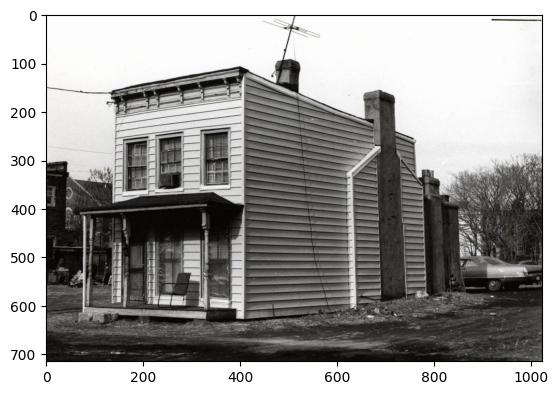

In [ ]:
# Знайомство з даними
# Візуалізуємо одне зображення з набору даних.

def display_image(image, print_info = True, hide_axis = False):
    if isinstance(image, str):  # Check if it's a file path
        img = Image.open(image)
        plt.imshow(img)
    elif isinstance(image, np.ndarray):  # Check if it's a NumPy array
        image = image[..., ::-1]  # BGR to RGB
        img = Image.fromarray(image)
        plt.imshow(img)
    else:
        raise ValueError("Unsupported image format")

    if print_info:
        print('Type: ', type(img), '\\n')
        print('Shape: ', np.array(img).shape, '\\n')

    if hide_axis:
        plt.axis('off')

    plt.show()


example_image_path = CFG.CUSTOM_DATASET_DIR + 'train/images/000ceb7c62a21547.jpg'
display_image(example_image_path, print_info = True, hide_axis = False)

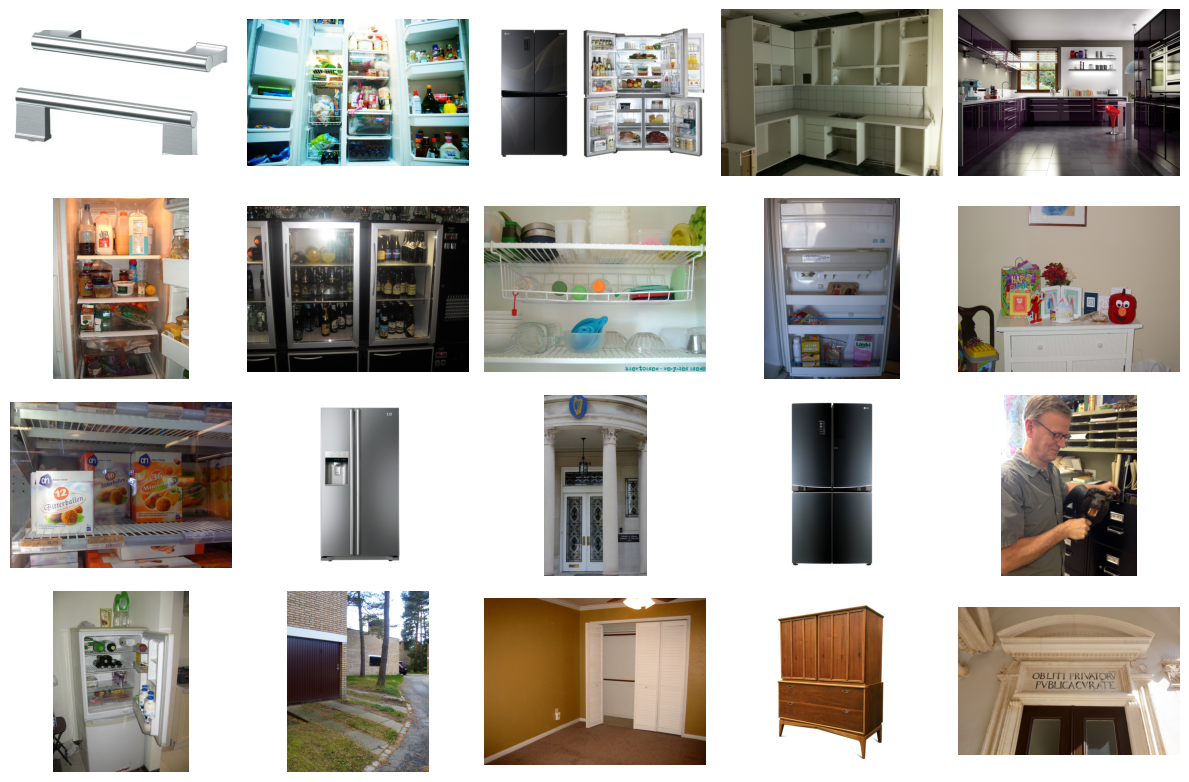

In [ ]:
# Візуалізуємо декілька випадкових зображень з набору даних.

def plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED):

    random.seed(seed)

    # Get a list of image files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg', '.gif'))]

    # Ensure that we have at least num_images files to choose from
    if len(image_files) < num_images:
        raise ValueError("Not enough images in the folder")

    # Randomly select num_images image files
    selected_files = random.sample(image_files, num_images)

    # Create a subplot grid
    num_cols = 5
    num_rows = (num_images + num_cols - 1) // num_cols
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))

    for i, file_name in enumerate(selected_files):
        # Open and display the image using PIL
        img = Image.open(os.path.join(folder_path, file_name))

        if num_rows == 1:
            ax = axes[i % num_cols]
        else:
            ax = axes[i // num_cols, i % num_cols]

        ax.imshow(img)
        ax.axis('off')
        # ax.set_title(file_name)

    # Remove empty subplots
    for i in range(num_images, num_rows * num_cols):
        if num_rows == 1:
            fig.delaxes(axes[i % num_cols])
        else:
            fig.delaxes(axes[i // num_cols, i % num_cols])

    plt.tight_layout()
    plt.show()

folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
plot_random_images_from_folder(folder_path, num_images=20, seed=CFG.SEED)

In [ ]:
# Для подальшої роботи нам треба зберегти основні властивості зображень цього набору даних.

def get_image_properties(image_path):
    # Read the image file
    img = cv2.imread(image_path)

    # Check if the image file is read successfully
    if img is None:
        raise ValueError("Could not read image file")

    # Get image properties
    properties = {
        "width": img.shape[1],
        "height": img.shape[0],
        "channels": img.shape[2] if len(img.shape) == 3 else 1,
        "dtype": img.dtype,
    }

    return properties

img_properties = get_image_properties(example_image_path)
img_properties

{'width': 1024, 'height': 715, 'channels': 3, 'dtype': dtype('uint8')}

In [ ]:
def get_images_properties_from_folder(folder_path):
    properties_list = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)

        # Перевіряємо, чи це файл зображення
        if file_path.endswith(('.jpg', '.png', '.jpeg', '.gif')):
            try:
                properties = get_image_properties(file_path)
                properties["file_name"] = file_name  # Додаємо ім'я файлу для ідентифікації
                properties_list.append(properties)
            except Exception as e:
                print(f"Error processing {file_name}: {e}")

    return properties_list

# Використання:
folder_path = CFG.CUSTOM_DATASET_DIR + 'train/images/'
all_properties = get_images_properties_from_folder(folder_path)

# Перевіряємо перші кілька значень
all_properties[:5]

[{'width': 1024,
  'height': 682,
  'channels': 3,
  'dtype': dtype('uint8'),
  'file_name': '263523d1754e3381.jpg'},
 {'width': 1024,
  'height': 1024,
  'channels': 3,
  'dtype': dtype('uint8'),
  'file_name': '1ae7acb4547d5bc0.jpg'},
 {'width': 1024,
  'height': 683,
  'channels': 3,
  'dtype': dtype('uint8'),
  'file_name': '0e8139635a72ecb8.jpg'},
 {'width': 764,
  'height': 1024,
  'channels': 3,
  'dtype': dtype('uint8'),
  'file_name': 'a0da5e7cc4ba2d79.jpg'},
 {'width': 1024,
  'height': 768,
  'channels': 3,
  'dtype': dtype('uint8'),
  'file_name': '0410943ef1919f80.jpg'}]

In [ ]:
# Підрахуємо кількість представників у кожному класі за всіма вибірками.
class_idx = {str(i): CFG.CLASSES[i] for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

class_stat = {}
data_len = {}
class_info = []

for mode in ['train', 'valid', 'test']:
    class_count = {CFG.CLASSES[i]: 0 for i in range(CFG.NUM_CLASSES_TO_TRAIN)}

    path = os.path.join(CFG.CUSTOM_DATASET_DIR, mode, 'labels')

    for file in os.listdir(path):
        with open(os.path.join(path, file)) as f:
            lines = f.readlines()

            for cls in set([line[0] for line in lines]):
                class_count[class_idx[cls]] += 1

    data_len[mode] = len(os.listdir(path))
    class_stat[mode] = class_count

    class_info.append({'Mode': mode, **class_count, 'Data_Volume': data_len[mode]})

dataset_stats_df = pd.DataFrame(class_info)
with pd.option_context('display.max_columns', None):
    display(dataset_stats_df)

,Mode,door,openedDoor,cabinetDoor,refrigeratorDoor,window,chair,table,cabinet,sofa/couch,pole,Data_Volume
0,train,309,448,332,187,105,165,138,22,68,14,1008
1,valid,63,99,85,39,24,30,28,1,13,4,230
2,test,25,42,1,49,38,41,44,31,18,3,104


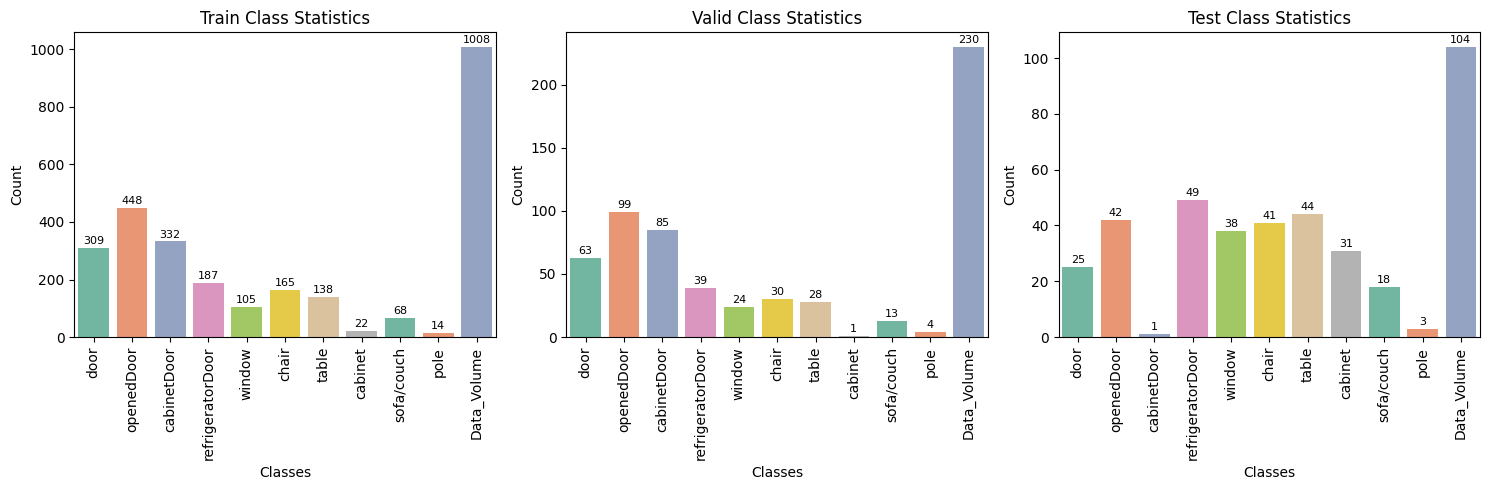

In [ ]:
# Візуалізуємо розподіл класів.
# Create subplots with 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot vertical bar plots for each mode in subplots
for i, mode in enumerate(['train', 'valid', 'test']):
    sns.barplot(
        data=dataset_stats_df[dataset_stats_df['Mode'] == mode].drop(columns='Mode'),
        orient='v',
        ax=axes[i],
        palette='Set2'
    )

    axes[i].set_title(f'{mode.capitalize()} Class Statistics')
    axes[i].set_xlabel('Classes')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=90)

    # Add annotations on top of each bar
    for p in axes[i].patches:
        axes[i].annotate(f"{int(p.get_height())}", (p.get_x() + p.get_width() / 2., p.get_height()),
                         ha='center', va='center', fontsize=8, color='black', xytext=(0, 5),
                         textcoords='offset points')

plt.tight_layout()
plt.show()

Спостерігаємо дисбаланс класів.

100%|██████████| 112M/112M [00:00<00:00, 175MB/s] 



image 1/1 /kaggle/input/indoor-object-detection/train/images/000da932ca7e68e4.jpg: 704x1024 2 beds, 69.2ms
Speed: 6.0ms preprocess, 69.2ms inference, 237.0ms postprocess per image at shape (1, 3, 704, 1024)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels
Type:  <class 'PIL.JpegImagePlugin.JpegImageFile'> \n
Shape:  (683, 1024, 3) \n


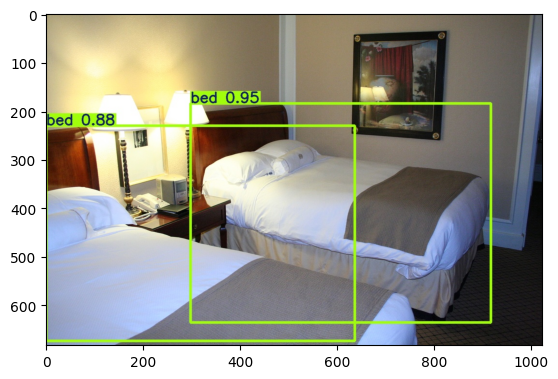

In [ ]:
example_image_path = CFG.CUSTOM_DATASET_DIR + 'train/images/000da932ca7e68e4.jpg'
# Давайте протестуємо попередньо навчену модель YOLOv9 на нашому тестовому прикладі. Для цього створимо об’єкт моделі YOLO та викличемо метод .predict().
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

results = model.predict(
    source = example_image_path,
    classes = [59],
    conf = 0.30,
#     device = [0,1], # inference with dual GPU
    device = None, # inference with CPU
    # imgsz = (img_properties['height'], img_properties['width']),
    imgsz = (int(img_properties['height'] // 32 * 32), int(img_properties['width'] // 32 * 32)),
    save = True,
    save_txt = True,
    save_conf = True,
    exist_ok = True,
)

example_image_inference_output = example_image_path.split('/')[-1]
display_image(f'runs/detect/predict/{example_image_inference_output}')

In [ ]:
print(model.names)

{0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microw

Бачимо, що попередньо навчена модель правильно розпізнає підібраний клас bed

In [ ]:
pip install ipython

Note: you may need to restart the kernel to use updated packages.


In [ ]:
model = YOLO(CFG.BASE_MODEL_WEIGHTS)

In [ ]:
# Для тренування викличемо метод .train нашої моделі.

model.train(
    data = os.path.join(CFG.OUTPUT_DIR, 'data.yaml'),

    task = 'detect',

    # imgsz = (img_properties['height'], img_properties['width']),
    imgsz = (int(img_properties['height'] // 32 * 32), int(img_properties['width'] // 32 * 32)),

    epochs = CFG.EPOCHS,
    batch = CFG.BATCH_SIZE,
    optimizer = CFG.OPTIMIZER,
    lr0 = CFG.LR,
    lrf = CFG.LR_FACTOR,
    weight_decay = CFG.WEIGHT_DECAY,
    dropout = CFG.DROPOUT,
    fraction = CFG.FRACTION,
    patience = CFG.PATIENCE,
    profile = CFG.PROFILE,
    label_smoothing = CFG.LABEL_SMOOTHING,

    name = f'{CFG.BASE_MODEL}_{CFG.EXP_NAME}',
    seed = CFG.SEED,

    val = True,
    amp = True,
    exist_ok = True,
    resume = False,
    device = [0], #  [0,1]
#     device = None, # CPU run
    verbose = False,
)

Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov9e.pt, data=./data.yaml, epochs=70, time=None, patience=20, batch=4, imgsz=(704, 1024), save=True, save_period=-1, cache=False, device=[0], workers=8, project=None, name=yolov9e_ppe_css_70_epochs, exist_ok=True, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

100%|██████████| 755k/755k [00:00<00:00, 17.4MB/s]
2024-11-24 23:00:48,704	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-11-24 23:00:49,128	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=10

                   from  n    params  module                                       arguments                     
  0                  -1  1         0  torch.nn.modules.linear.Identity             []                            
  1                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  2                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  3                  -1  1    252160  ultralytics.nn.modules.block.RepNCSPELAN4    [128, 256, 128, 64, 2]        
  4                  -1  1    164352  ultralytics.nn.modules.block.ADown           [256, 256]                    
  5                  -1  1   1004032  ultralytics.nn.modules.block.RepNCSPELAN4    [256, 512, 256, 128, 2]       
  6                  -1  1    656384  ultralytics.nn.modules.block.ADown           [512, 512]                    
  7                  -1  1   4006912  ultralytic

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.1MB/s]


AMP: checks passed ✅
WARNING ⚠️ updating to 'imgsz=1024'. 'train' and 'val' imgsz must be an integer, while 'predict' and 'export' imgsz may be a [h, w] list or an integer, i.e. 'yolo export imgsz=640,480' or 'yolo export imgsz=640'


train: Scanning /kaggle/input/indoor-object-detection/train/labels... 1008 images, 120 backgrounds, 0 corrupt: 100%|██████████| 1012/1012 [00:01<00:00, 823.84it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/train is not writeable, cache not saved.


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/input/indoor-object-detection/valid/labels... 230 images, 31 backgrounds, 0 corrupt: 100%|██████████| 230/230 [00:00<00:00, 299.55it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/indoor-object-detection/valid is not writeable, cache not saved.


Plotting labels to runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 298 weight(decay=0.0), 310 weight(decay=0.0005), 309 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 4 dataloader workers
Logging results to runs/detect/yolov9e_ppe_css_70_epochs
Starting training for 70 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/70      15.4G      1.656      2.844      1.756         35       1024: 100%|██████████| 253/253 [05:37<00:00,  1.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:19<00:00,  1.48it/s]

                   all        230       1289      0.352      0.135     0.0769     0.0415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/70      15.2G      1.732      2.564      1.828         70       1024: 100%|██████████| 253/253 [05:32<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]

                   all        230       1289      0.374       0.15      0.072     0.0351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/70      15.2G      1.767      2.721      1.855         23       1024: 100%|██████████| 253/253 [05:31<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]

                   all        230       1289      0.417       0.13     0.0862     0.0404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/70      15.2G      1.745      2.697       1.86         29       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:18<00:00,  1.61it/s]

                   all        230       1289       0.51      0.092     0.0742      0.035



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/70      15.2G      1.675      2.535      1.809         62       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.62it/s]

                   all        230       1289      0.437      0.112     0.0939     0.0457



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/70      15.2G      1.651      2.495      1.786         32       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]

                   all        230       1289        0.6      0.146      0.105     0.0529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/70      13.6G      1.637      2.391      1.767         70       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.605      0.187      0.107     0.0562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/70      15.2G      1.598      2.352      1.753         28       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.63it/s]

                   all        230       1289      0.555      0.168      0.122     0.0613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/70      15.2G      1.624      2.278      1.764         35       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]

                   all        230       1289       0.68       0.16      0.148     0.0771



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/70      15.5G      1.566      2.229      1.712         47       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]

                   all        230       1289      0.458      0.185      0.149     0.0822



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/70      15.2G      1.543      2.184        1.7         25       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]

                   all        230       1289      0.475      0.177      0.155     0.0838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/70      15.2G      1.539      2.123      1.691         25       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]

                   all        230       1289      0.459      0.247      0.183     0.0986



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/70      15.2G      1.519      2.061      1.669         12       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.569      0.232      0.203      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/70      15.2G      1.528      2.071      1.685         23       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.614      0.206      0.192       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/70      15.2G      1.488      2.021       1.66         16       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.481      0.225      0.202      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/70      15.2G      1.464      1.929      1.643         20       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.444      0.219      0.203      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/70      15.2G       1.47      1.962      1.646         51       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.505      0.245      0.193      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/70      15.2G      1.478      1.947      1.665         56       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]

                   all        230       1289      0.514      0.252      0.218      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/70      15.2G      1.466      1.872      1.636         22       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]

                   all        230       1289      0.553      0.274      0.224      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/70      15.2G      1.443      1.858      1.617         40       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]

                   all        230       1289      0.525      0.249      0.212      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/70      15.2G      1.453      1.842      1.627         18       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]

                   all        230       1289      0.533      0.273      0.216      0.124



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/70      15.2G      1.423      1.764      1.599         52       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.552      0.277      0.239      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/70      15.2G      1.392       1.75        1.6         11       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.566      0.286      0.237      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/70      15.2G      1.401      1.765      1.598         34       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.562      0.269      0.236      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/70      15.2G      1.394      1.755      1.599         20       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]

                   all        230       1289       0.48      0.285      0.255      0.144



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/70      15.5G        1.4      1.673      1.592         57       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]

                   all        230       1289      0.568      0.309      0.264      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/70      15.2G      1.352      1.568       1.56         26       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.603      0.268      0.264      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/70      15.2G       1.39      1.617      1.577         31       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.601      0.329      0.268      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/70      15.2G      1.354      1.575      1.556         40       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.466      0.315      0.263       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/70      15.2G      1.352      1.536      1.571         66       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.644      0.265      0.278       0.16



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/70      15.2G      1.348      1.613      1.552         13       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.623      0.255      0.262      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/70      13.6G      1.328      1.528      1.549         29       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.67it/s]

                   all        230       1289      0.618      0.298      0.281      0.163



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/70      15.2G      1.337      1.507      1.541         27       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.686      0.279      0.285      0.166



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/70      15.2G      1.329      1.461      1.542         83       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.488      0.336      0.299      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/70      13.6G      1.325      1.457      1.525         61       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.67it/s]

                   all        230       1289      0.584      0.283      0.302      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/70      15.2G      1.273      1.428      1.506         28       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.435      0.336      0.285      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/70      15.2G      1.312      1.412      1.531         89       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.571      0.299      0.299      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/70      15.2G      1.274       1.39      1.499         26       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289       0.49      0.323      0.301      0.182



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/70      15.2G      1.277      1.356      1.493         29       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.548      0.317      0.312      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/70      13.6G      1.272      1.351      1.496         61       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.67it/s]

                   all        230       1289      0.523      0.301      0.297      0.176



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/70      15.2G      1.257      1.337      1.479         16       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]

                   all        230       1289      0.518      0.361       0.33      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/70      15.5G      1.255      1.275       1.48         27       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289       0.54      0.315      0.317       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/70      15.2G      1.258      1.284      1.492         65       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.559      0.314      0.327      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/70      15.2G      1.224       1.26      1.456         19       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.652      0.324      0.325      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/70      15.2G      1.225      1.251      1.465         32       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.717       0.32      0.329      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/70      15.2G      1.222       1.23      1.452         24       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.464      0.384      0.321      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/70      15.2G      1.217       1.22      1.452         27       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.627      0.331      0.332        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/70      15.2G      1.204      1.208      1.464         53       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.546      0.336       0.33      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/70      15.4G        1.2      1.182      1.433         67       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.424      0.319      0.341      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/70      13.6G      1.181      1.149       1.42         45       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.67it/s]

                   all        230       1289      0.472      0.349      0.351      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/70      15.2G      1.172       1.16      1.436         46       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.346       0.41      0.362      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/70      15.4G      1.153      1.086      1.403         13       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.645      0.313       0.34      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/70      13.8G      1.159      1.113      1.411         21       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.67it/s]

                   all        230       1289      0.687      0.306      0.339        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/70      15.4G      1.141      1.096       1.41         33       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.441      0.368      0.355      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/70      15.4G       1.13      1.084      1.393         55       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.67it/s]

                   all        230       1289      0.423      0.364      0.343      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/70      14.5G      1.153      1.034      1.401         13       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.67it/s]

                   all        230       1289      0.575      0.317      0.355      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/70      15.2G      1.104       1.01      1.374         29       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.64it/s]

                   all        230       1289      0.488      0.342      0.359      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/70      15.5G      1.089     0.9886      1.358         11       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.373      0.365      0.358      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/70      15.2G       1.12     0.9981      1.385         36       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.674      0.332      0.354      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/70      15.2G      1.084     0.9926      1.354         50       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.383      0.389      0.364      0.222


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/70      13.6G      1.079     0.9578      1.362         26       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.67it/s]

                   all        230       1289      0.544      0.355      0.358      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/70      15.2G      1.079     0.8918      1.374         14       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.366      0.396      0.361      0.219



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/70      13.6G      1.056     0.9384      1.348         30       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.67it/s]

                   all        230       1289      0.398      0.393      0.361      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/70      15.2G      1.039     0.8241      1.337          6       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.406      0.362      0.364      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/70      15.2G      1.021     0.8397       1.31         11       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.455      0.322      0.349       0.21



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/70      15.2G      1.022     0.8033      1.345         10       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.388      0.372      0.362      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/70      15.2G      1.004      1.127      1.326         22       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.363      0.386      0.357      0.216



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/70      15.2G      1.006     0.7797      1.309         69       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.341      0.409      0.362      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/70      15.2G     0.9862     0.7484      1.305         27       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.65it/s]

                   all        230       1289      0.396      0.379      0.373      0.228



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/70      15.2G      0.974     0.7477      1.299         11       1024: 100%|██████████| 253/253 [05:30<00:00,  1.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.66it/s]

                   all        230       1289      0.425      0.368      0.367      0.223



70 epochs completed in 6.834 hours.
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/last.pt, 117.3MB
Optimizer stripped from runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt, 117.3MB

Validating runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt...
Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLOv9e summary (fused): 687 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 29/29 [00:17<00:00,  1.70it/s]


                   all        230       1289      0.396      0.376      0.372      0.227
Speed: 0.3ms preprocess, 70.0ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/yolov9e_ppe_css_70_epochs


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a9a516d5bd0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.0

# Детекція об’єктів. Аналіз результатів

In [ ]:
# Збережемо ваги натренованої моделі. Для цього використаємо режим експорту.
# У цьому режимі модель перетворюється у формат, який можна використовувати іншими програмними застосунками чи апаратними пристроями.
# Цей режим корисний під час розгортання моделі у виробничих середовищах.
# Export the model
model.export(
    format = 'onnx', # openvino, onnx, engine, tflite
    imgsz = (img_properties['height'], img_properties['width']),
    half = False,
    int8 = False,
    simplify = False,
    nms = False,
)

# Формат моделі ONNX (Open Neural Network Exchange) — це відкритий стандарт для представлення моделей машинного навчання.
# Він дозволяє переносити моделі між різними фреймворками та інструментами для машинного навчання, такими як PyTorch, TensorFlow тощо,
# забезпечуючи сумісність і спрощуючи інтероперабельність.
# Це дозволяє користувачам тренувати модель в одному середовищі й використовувати її для розгортання в іншому.

Ultralytics 8.3.36 🚀 Python-3.10.14 torch-2.4.0 CPU (Intel Xeon 2.00GHz)
WARNING ⚠️ imgsz=[715, 1024] must be multiple of max stride 32, updating to [736, 1024]
YOLOv9e summary (fused): 687 layers, 57,384,110 parameters, 0 gradients, 189.2 GFLOPs

PyTorch: starting from 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.pt' with input shape (1, 3, 736, 1024) BCHW and output shape(s) (1, 14, 15456) (111.9 MB)

ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: export success ✅ 7.9s, saved as 'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx' (219.4 MB)

Export complete (20.0s)
Results saved to /kaggle/working/runs/detect/yolov9e_ppe_css_70_epochs/weights
Predict:         yolo predict task=detect model=runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx imgsz=736,1024  
Validate:        yolo val task=detect model=runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx imgsz=736,1024 data=./data.yaml  WARNING ⚠️ non-PyTorch val requires square images, 'imgsz=[736, 1024]'

'runs/detect/yolov9e_ppe_css_70_epochs/weights/best.onnx'

In [ ]:
results

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted p

In [ ]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([59., 59.], device='cuda:0')
conf: tensor([0.9546, 0.8770], device='cuda:0')
data: tensor([[2.9808e+02, 1.8489e+02, 9.1853e+02, 6.3610e+02, 9.5464e-01, 5.9000e+01],
        [9.5471e-01, 2.3055e+02, 6.3714e+02, 6.7490e+02, 8.7701e-01, 5.9000e+01]], device='cuda:0')
id: None
is_track: False
orig_shape: (683, 1024)
shape: torch.Size([2, 6])
xywh: tensor([[608.3059, 410.4952, 620.4432, 451.2194],
        [319.0465, 452.7262, 636.1836, 444.3430]], device='cuda:0')
xywhn: tensor([[0.5940, 0.6010, 0.6059, 0.6606],
        [0.3116, 0.6628, 0.6213, 0.6506]], device='cuda:0')
xyxy: tensor([[298.0843, 184.8855, 918.5275, 636.1049],
        [  0.9547, 230.5547, 637.1383, 674.8977]], device='cuda:0')
xyxyn: tensor([[2.9110e-01, 2.7070e-01, 8.9700e-01, 9.3134e-01],
        [9.3234e-04, 3.3756e-01, 6.2221e-01, 9.8814e-01]], device='cuda:0')

In [ ]:
# YOLO зберігає результати тренування, зокрема різні метрики, у папці runs/detect.
# Збережемо шляхи до всіх зображень з результатами до змінної results_paths.
results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'batch' not in i
]

results_paths

['./runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/results.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png',
 './runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg',
 './runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg']

./runs/detect/yolov9e_ppe_css_70_epochs/F1_curve.png


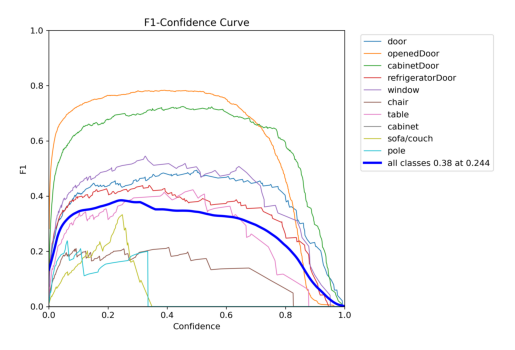



./runs/detect/yolov9e_ppe_css_70_epochs/PR_curve.png


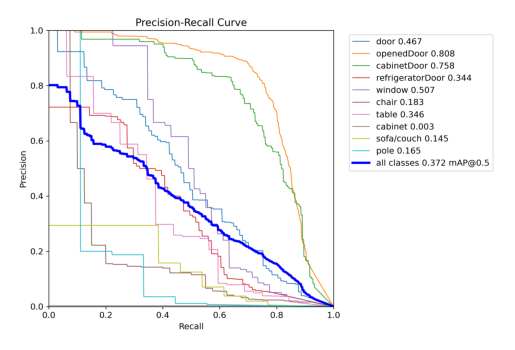



./runs/detect/yolov9e_ppe_css_70_epochs/P_curve.png


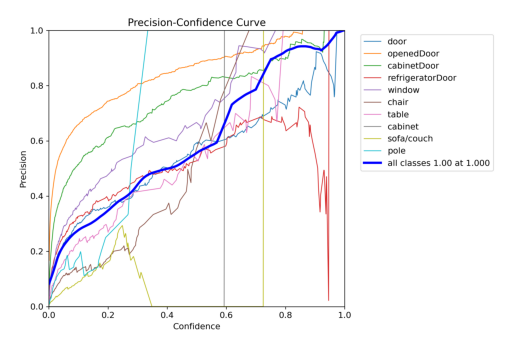



./runs/detect/yolov9e_ppe_css_70_epochs/R_curve.png


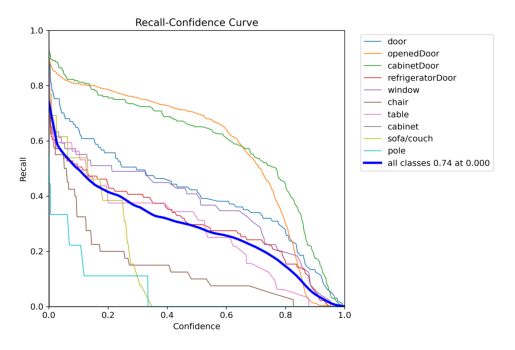



./runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix.png


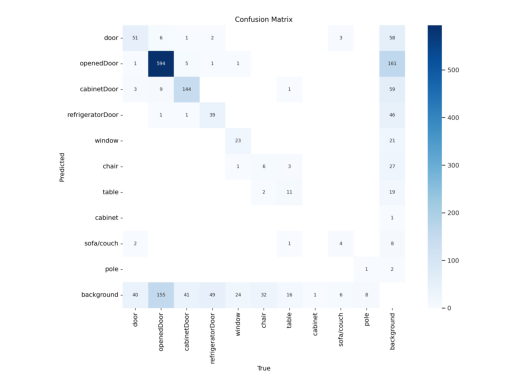



./runs/detect/yolov9e_ppe_css_70_epochs/confusion_matrix_normalized.png


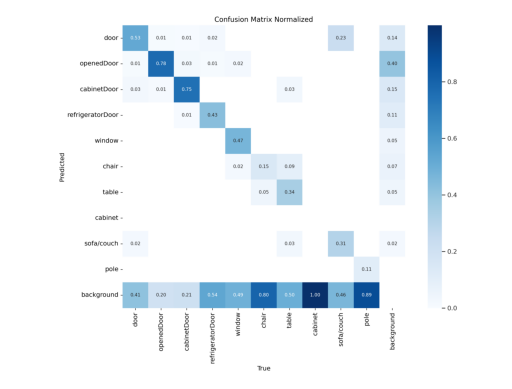



./runs/detect/yolov9e_ppe_css_70_epochs/labels.jpg


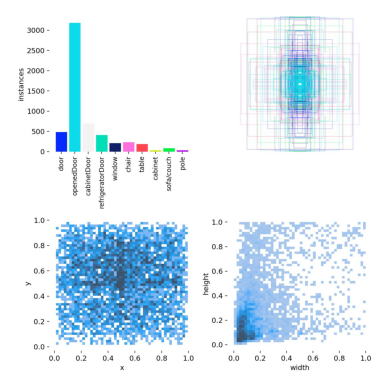



./runs/detect/yolov9e_ppe_css_70_epochs/labels_correlogram.jpg


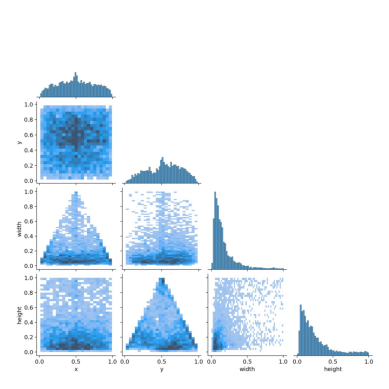



./runs/detect/yolov9e_ppe_css_70_epochs/results.png


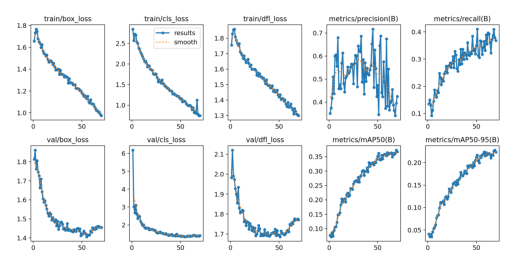

In [ ]:
# Аналіз отриманих результатів

for file in sorted(results_paths):
    print(file)
    display_image(file, print_info = False, hide_axis = True)
    print('\n')

In [ ]:
df = pd.read_csv(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/results.csv')
df = df.rename(columns=lambda x: x.replace(" ", ""))
df.to_csv(f'{CFG.OUTPUT_DIR}training_log_df.csv', index=False)
df

,epoch,time,train/box_loss,train/cls_loss,train/dfl_loss,metrics/precision(B),metrics/recall(B),metrics/mAP50(B),metrics/mAP50-95(B),val/box_loss,val/cls_loss,val/dfl_loss,lr/pg0,lr/pg1,lr/pg2
0,1,372.527,1.65628,2.84449,1.75588,0.35151,0.13463,0.07688,0.04151,1.81314,6.17934,1.98175,0.000237,0.000237,0.000237
1,2,725.463,1.73164,2.56432,1.82835,0.37427,0.15035,0.07196,0.03507,1.86148,3.01690,2.12050,0.000468,0.000468,0.000468
2,3,1077.260,1.76712,2.72111,1.85480,0.41717,0.13020,0.08621,0.04039,1.76234,2.68527,1.99080,0.000693,0.000693,0.000693
3,4,1428.440,1.74471,2.69729,1.85952,0.50966,0.09198,0.07423,0.03497,1.80560,3.09525,1.97292,0.000684,0.000684,0.000684
4,5,1779.650,1.67514,2.53531,1.80899,0.43698,0.11210,0.09391,0.04569,1.74698,2.61446,1.92748,0.000674,0.000674,0.000674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,66,23196.600,1.02218,0.80335,1.34531,0.38767,0.37170,0.36180,0.21777,1.46023,1.37472,1.77586,0.000058,0.000058,0.000058
66,67,23547.100,1.00443,1.12676,1.32553,0.36347,0.38561,0.35739,0.21623,1.46105,1.39988,1.77103,0.000048,0.000048,0.000048
67,68,23897.400,1.00640,0.77973,1.30901,0.34121,0.40903,0.36234,0.22549,1.45601,1.39563,1.77250,0.000037,0.000037,0.000037
68,69,24248.500,0.98623,0.74839,1.30460,0.39567,0.37884,0.37284,0.22778,1.45698,1.37651,1.77524,0.000027,0.000027,0.000027


In [ ]:
print('*'*50)
print('\nBest Training Box loss: ', df['train/box_loss'].min(), ', on epoch: ', df['train/box_loss'].argmin() + 1, '\n')
print('\nBest Validation Box loss: ', df['val/box_loss'].min(), ', on epoch: ', df['val/box_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training Cls loss: ', df['train/cls_loss'].min(), ', on epoch: ', df['train/cls_loss'].argmin() + 1, '\n')
print('\nBest Validation Cls loss: ', df['val/cls_loss'].min(), ', on epoch: ', df['val/cls_loss'].argmin() + 1, '\n')

print('='*50)
print('\nBest Training DFL loss: ', df['train/dfl_loss'].min(), ', on epoch: ', df['train/dfl_loss'].argmin() + 1, '\n')
print('\nBest Validation DFL loss: ', df['val/dfl_loss'].min(), ', on epoch: ', df['val/dfl_loss'].argmin() + 1, '\n')

**************************************************

Best Training Box loss:  0.97403 , on epoch:  70 


Best Validation Box loss:  1.40614 , on epoch:  55 


Best Training Cls loss:  0.7477 , on epoch:  70 


Best Validation Cls loss:  1.34046 , on epoch:  55 


Best Training DFL loss:  1.29905 , on epoch:  70 


Best Validation DFL loss:  1.68612 , on epoch:  51 



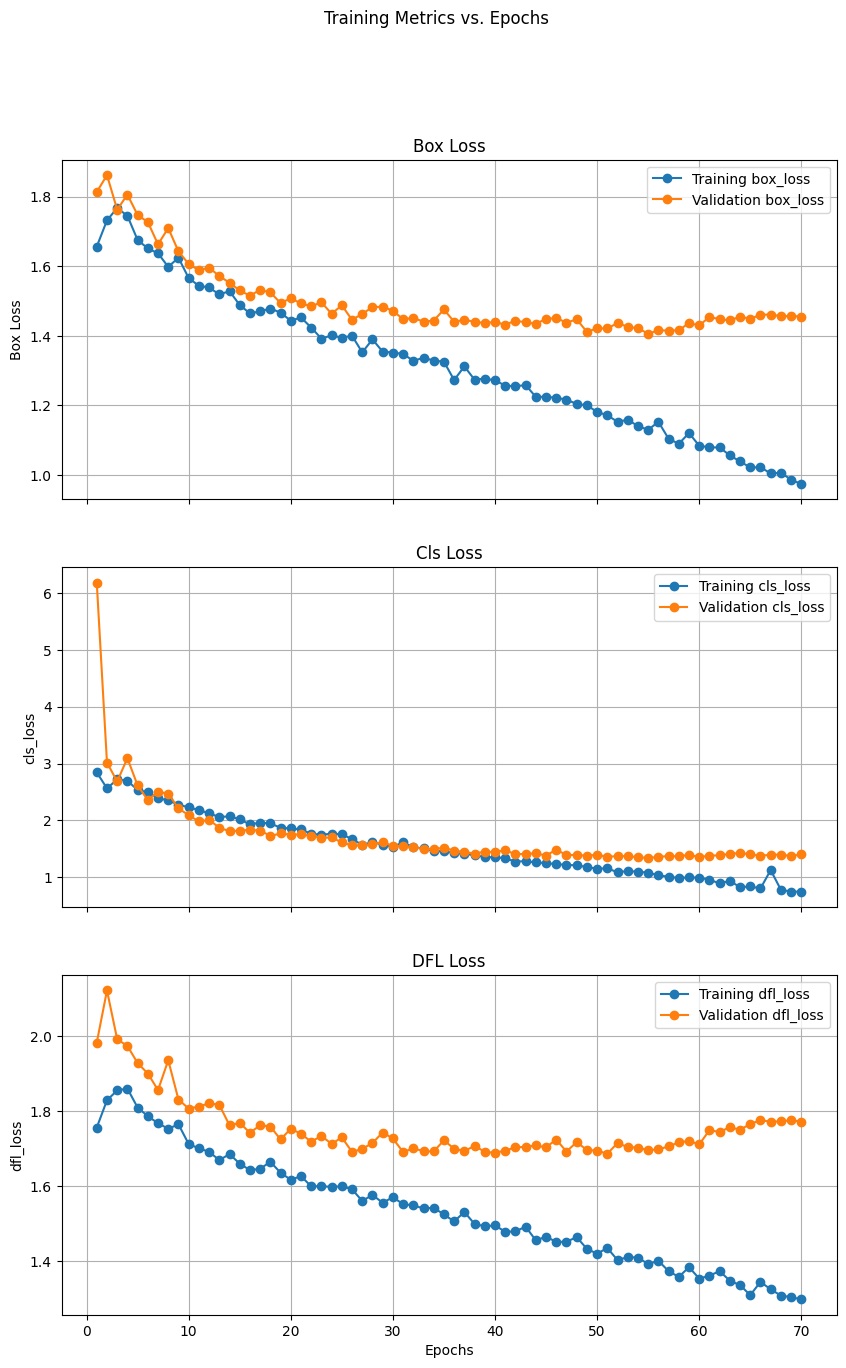

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

### Training and Validation box_loss
ax1.set_title('Box Loss')
ax1.plot(df['epoch'], df['train/box_loss'], label='Training box_loss', marker='o', linestyle='-')
ax1.plot(df['epoch'], df['val/box_loss'], label='Validation box_loss', marker='o', linestyle='-')
ax1.set_ylabel('Box Loss')
ax1.legend()
ax1.grid(True)

### Training and Validation cls_loss
ax2.set_title('Cls Loss')
ax2.plot(df['epoch'], df['train/cls_loss'], label='Training cls_loss', marker='o', linestyle='-')
ax2.plot(df['epoch'], df['val/cls_loss'], label='Validation cls_loss', marker='o', linestyle='-')
ax2.set_ylabel('cls_loss')
ax2.legend()
ax2.grid(True)

### Training and Validation dfl_loss
ax3.set_title('DFL Loss')
ax3.plot(df['epoch'], df['train/dfl_loss'], label='Training dfl_loss', marker='o', linestyle='-')
ax3.plot(df['epoch'], df['val/dfl_loss'], label='Validation dfl_loss', marker='o', linestyle='-')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('dfl_loss')
ax3.legend()
ax3.grid(True)

plt.suptitle('Training Metrics vs. Epochs')
plt.show()

In [ ]:
# Розглянемо приклади детекції на валідаційному наборі даних.
validation_results_paths = [
    i for i in
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.png') +
    glob.glob(f'{CFG.OUTPUT_DIR}runs/detect/{CFG.BASE_MODEL}_{CFG.EXP_NAME}/*.jpg')
    if 'val_batch' in i
]

len(validation_results_paths)

6

In [ ]:
if len(validation_results_paths) >= 1:
    print(validation_results_paths[-1])

./runs/detect/yolov9e_ppe_css_70_epochs/val_batch1_pred.jpg


./runs/detect/yolov9e_ppe_css_70_epochs/val_batch1_pred.jpg


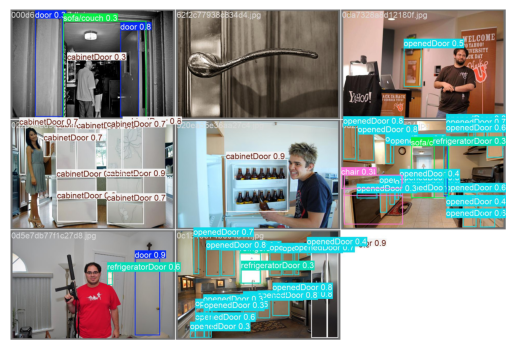

In [ ]:
### check predictions or labels from a random validation batch
if len(validation_results_paths) >= 1:
    val_img_path = random.choice(validation_results_paths)
    print(val_img_path)
    display_image(val_img_path, print_info = False, hide_axis = True)

In [ ]:
print(model.names)

{0: 'door', 1: 'openedDoor', 2: 'cabinetDoor', 3: 'refrigeratorDoor', 4: 'window', 5: 'chair', 6: 'table', 7: 'cabinet', 8: 'sofa/couch', 9: 'pole'}


# Аналіз результатів:
- Крива F1-Confidence показує що якщо ми встановимо threshold впевненості в передбаченні на рівні 0.244, наша модель матиме F1 майже 0.38, що не достатньо добре.
- Також бачимо що найкраще класифікується openDoor та cabinetDorr (біля 0.7-0.8), найгірше - pole, chair, sofa/couch
- Друга крива, яка демонструє компроміси між Precision і Recall при різних порогах, показує що, для класів pole та chair, ми маємо нижче значення mAP@0.5, ніж для інших класів. Ці класи найменш представлені в нашому дадасеті, тому може бути доречним використання більшої кількості даних для таких класів або корегування ваг класу під час навчання.
- Середнє mAP@0.5 також недостатньо високе — 0.37. Це свідчить про низькі значення як Precision, так і Recall.
- З confusion matrix ми бачимо:
 - cabitet (який тільки один) не було класифіковано(0%);
 - також погано класифіковано pole та chair (11% та 15%);
 - 23% door було розпізнано як sofa/coach;
 - та інші момилкові розпізнання

- Training Box Loss (0.98) значно нижчий за Validation Box Loss (1.45), що може свідчити про перенавчання.
- Training Classification Loss (0.8) також нижчий за Validation Classification Loss (1.4), що вказує на розрив у навчанні, який може бути спричинений незбалансованістю класів, невеликою кількістю даних або слабким узагальненням моделі.
- Training DFL Loss (1.25) кращий, ніж Validation DFL Loss (1.75), що також вказує на проблему з генералізацією і може бути пов’язане з занадто складною функцією втрат, яка вимагає більшого обсягу даних або покращення якості їх підготовки.



# Висновки:
- Низьке значення mAP@0.5 (0.37), погані результати для класів pole, chair, cabinet, і високий рівень помилкових класифікацій вказують на необхідність значних покращень у даних і налаштуваннях моделі. Орієнтуючись на збільшення даних і врахування ваг класів, можна досягти вищої точності.

- Всі три втрати (Box, Cls, DFL) мають суттєво вищі значення на валідаційних даних порівняно з тренувальними. Це свідчить про ймовірне перенавчання.

# Рекомендації:
- Розширення даних для класів з низьким представленням (за можливості), особливо pole, chair, і cabinet.
- Використати методи Data Augmentation, щоб підвищити варіативність зображень для недостатньо представлених класів.
- Застосувати балансування класів (oversampling/undersampling або ваги класів у функції втрат)
- Розглянути можливість використання більш потужної архітектури, наприклад, для кращого узагальнення на складних класах.
- Скорегувати гіперпараметри:
 - Переглянути поріг впевненості (threshold) та протестувати інші значення, щоб знайти оптимальний компроміс між Precision і Recall.
 - Спробувати додати регуляризаційні методи, такі як Dropout, Weight Decay.
 - Перевірте різні значення learning rate, batch size.



